# Modeling and Simulation in Python

Chapter 21

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### With air resistance

Next we'll add air resistance using the [drag equation](https://en.wikipedia.org/wiki/Drag_equation)

I'll start by getting the units we'll need from Pint.

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram

<Unit('kilogram')>

Now I'll create a `Params` object to contain the quantities we need.  Using a Params object is convenient for grouping the system parameters in a way that's easy to read (and double-check).

In [3]:
params = Params(height = 381 * m,
                v_init = 0 * m / s,
                g = 9.8 * m/s**2,
                mass = 2.5e-3 * kg,
                diameter = 19e-3 * m,
                rho = 1.2 * kg/m**3,
                v_term = 18 * m / s)

,values
height,381 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,0.0025 kilogram
diameter,0.019 meter
rho,1.2 kilogram / meter ** 3
v_term,18.0 meter / second


Now we can pass the `Params` object `make_system` which computes some additional parameters and defines `init`.

`make_system` uses the given radius to compute `area` and the given `v_term` to compute the drag coefficient `C_d`.

In [4]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    diameter, mass = params.diameter, params.mass
    g, rho = params.g, params.rho, 
    v_init, v_term = params.v_init, params.v_term
    height = params.height
    
    area = np.pi * (diameter/2)**2
    C_d = 2 * mass * g / (rho * area * v_term**2)
    init = State(y=height, v=v_init)
    t_end = 30 * s
    dt = t_end / 100
    
    return System(params, area=area, C_d=C_d, 
                  init=init, t_end=t_end, dt=dt)

Let's make a `System`

In [5]:
system = make_system(params)

,values
height,381 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,0.0025 kilogram
diameter,0.019 meter
rho,1.2 kilogram / meter ** 3
v_term,18.0 meter / second
area,0.0002835287369864788 meter ** 2
C_d,0.4445009981135434 dimensionless
init,y 381 meter v 0.0 meter / secon...


Here's the slope function, including acceleration due to gravity and drag.

In [6]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object
    
    returns: derivatives of y and v
    """
    y, v = state
    rho, C_d, g = system.rho, system.C_d, system.g
    area, mass = system.area, system.mass
    
    f_drag = rho * v**2 * C_d * area / 2
    a_drag = f_drag / mass
    
    dydt = v
    dvdt = -g + a_drag
    
    return dydt, dvdt

As always, let's test the slope function with the initial conditions.

In [7]:
slope_func(system.init, 0, system)

(0.0 <Unit('meter / second')>, -9.8 <Unit('meter / second ** 2')>)

We can use the same event function as in the previous chapter.

In [8]:
def event_func(state, t, system):
    """Return the height of the penny above the sidewalk.
    """
    y, v = state
    return y

And then run the simulation.

In [9]:
results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
success,True
message,A termination event occurred.


Here are the results.

In [10]:
results.head()

,y,v
0.0,381 meter,0.0 meter / second
0.3,380.559 meter,-2.913855777777778 meter / second
0.6,379.2553998560887 meter,-5.676321799192868 meter / second
0.9,377.15535917269835 meter,-8.166374221525693 meter / second
1.2,374.35521895425103 meter,-10.311720070623485 meter / second


In [11]:
results.tail()

,y,v
21.300000,20.486949941310563 meter,-17.99999999508715 meter / second
21.600000,15.086949942543686 meter,-17.99999999642989 meter / second
21.900000,9.686949943439785 meter,-17.99999999740564 meter / second
22.200000,4.286949944090969 meter,-17.999999998114706 meter / second
22.438164,0.0 meter,-17.99999999852377 meter / second


The final height is close to 0, as expected.

Interestingly, the final velocity is not exactly terminal velocity, which suggests that there are some numerical errors.

We can get the flight time from `results`.

In [12]:
t_sidewalk = get_last_label(results) * s

22.438163885803732 <Unit('second')>

Here's the plot of position as a function of time.

Saving figure to file figs/chap21-fig01.pdf


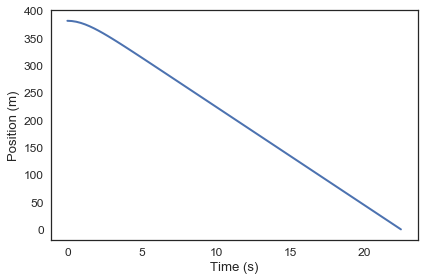

In [13]:
def plot_position(results):
    plot(results.y)
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')
    
plot_position(results)
savefig('figs/chap21-fig01.pdf')

And velocity as a function of time:

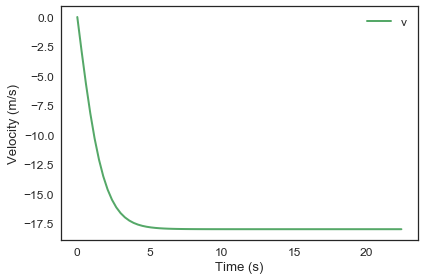

In [14]:
def plot_velocity(results):
    plot(results.v, color='C1', label='v')
        
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/s)')
    
plot_velocity(results)

From an initial velocity of 0, the penny accelerates downward until it reaches terminal velocity; after that, velocity is constant.

## Exercise

Run the simulation with an initial velocity, downward, that exceeds the penny's terminal velocity.  Hint: You can create a new `Params` object based on an existing one, like this:

`params2 = Params(params, v_init=-30 * m/s)`

What do you expect to happen?  Plot velocity and position as a function of time, and see if they are consistent with your prediction.

### Comments: 

I changed initial velocity to -10, velocity increased until it reached terminal velocity. 

However, when I changed initial velocity to -20, velocity decreased until it reached terminal velocity. 

In [31]:
# Solution goes here
params2 = Params(params, v_init=-20 * m/s)
system2 = make_system(params2)

,values
height,381 meter
v_init,-20.0 meter / second
g,9.8 meter / second ** 2
mass,0.0025 kilogram
diameter,0.019 meter
rho,1.2 kilogram / meter ** 3
v_term,18.0 meter / second
area,0.0002835287369864788 meter ** 2
C_d,0.4445009981135434 dimensionless
init,y 381 meter v -20.0 meter / s...


In [32]:
# Solution goes here
results2, details2 = run_ode_solver(system2, slope_func, events=event_func)
details2

,values
success,True
message,A termination event occurred.


In [33]:
results2.head()

,y,v
0.0,381 meter,-20.0 meter / second
0.3,375.10344444444445 meter,-19.434086867211978 meter / second
0.6,369.34628790888513 meter,-19.03214258001648 meter / second
0.9,363.68867013788343 meter,-18.744843174439822 meter / second
1.2,358.102469633776 meter,-18.538549277253765 meter / second


In [34]:
results2.tail()

,y,v
20.100000,17.41147681772164 meter,-18.000000000978144 meter / second
20.400000,12.011476817476124 meter,-18.000000000710806 meter / second
20.700000,6.611476817297713 meter,-18.000000000516536 meter / second
21.000000,1.2114768171680623 meter,-18.000000000375362 meter / second
21.067304,0.0 meter,-18.000000000352347 meter / second


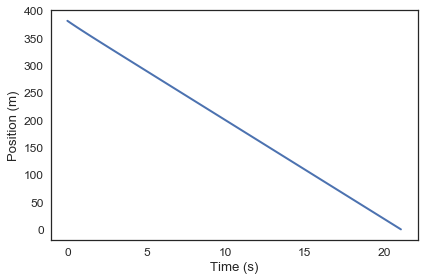

In [35]:
plot_position(results2)

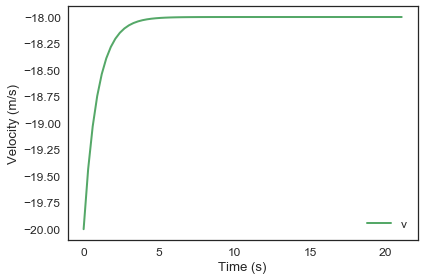

In [36]:
# Solution goes here
plot_velocity(results2)

## Exercise

Suppose we drop a quarter from the Empire State Building and find that its flight time is 19.1 seconds.  Use this measurement to estimate the terminal velocity.

1. You can get the relevant dimensions of a quarter from https://en.wikipedia.org/wiki/Quarter_(United_States_coin).

2. Create a `Params` object with the system parameters.  We don't know `v_term`, so we'll start with the inital guess `v_term = 18 * m / s`.

3. Use `make_system` to create a `System` object.

4. Call `run_ode_solver` to simulate the system.  How does the flight time of the simulation compare to the measurement?

5. Try a few different values of `t_term` and see if you can get the simulated flight time close to 19.1 seconds.

6. Optionally, write an error function and use `root_scalar` to improve your estimate.

7. Use your best estimate of `v_term` to compute `C_d`.

Note: I fabricated the observed flight time, so don't take the results of this exercise too seriously.


### Comments:

So, with v_term = 18, the flight time is 21.067304 seconds. 

After doing a few tries to get the flight time as close as possible to 19.1 seconds, I decided to focus investigation of v_term between -21.68 and -21.69 by creating an array within this window. I then ran the simulation a few times to get as close as possible to 19.1 seconds. 



In [104]:
# Solution goes here
params3 = Params(height = 381 * m,
                v_init = 0 * m / s,
                g = 9.8 * m/s**2,
                mass = 2.5e-3 * kg,
                diameter = 19e-3 * m,
                rho = 1.2 * kg/m**3,
                v_term = 21.68 * m / s)

,values
height,381 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,0.0025 kilogram
diameter,0.019 meter
rho,1.2 kilogram / meter ** 3
v_term,21.68 meter / second


In [105]:
# Solution goes here
system3 = make_system(params3)

,values
height,381 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,0.0025 kilogram
diameter,0.019 meter
rho,1.2 kilogram / meter ** 3
v_term,21.68 meter / second
area,0.0002835287369864788 meter ** 2
C_d,0.30640736141253705 dimensionless
init,y 381 meter v 0.0 meter / secon...


In [106]:
# Solution goes here
results3, details3 = run_ode_solver(system3, slope_func, events=event_func)
details3

,values
success,True
message,A termination event occurred.


In [107]:
# Solution goes here
results3.tail()

,y,v
18.000000,23.974326494881815 meter,-21.679995404707487 meter / second
18.300000,17.470327686520882 meter,-21.679996482019458 meter / second
18.600000,10.966328598794261 meter,-21.679997306768396 meter / second
18.900000,4.462329297195933 meter,-21.679997938164707 meter / second
19.105827,0.0 meter,-21.679998269802052 meter / second


In [147]:
# Solution goes here
v_term_array = linspace(-21.68, -21.69, 10)

array([-21.68      , -21.68111111, -21.68222222, -21.68333333,
       -21.68444444, -21.68555556, -21.68666667, -21.68777778,
       -21.68888889, -21.69      ])

In [148]:
# Solution goes here
my_results = TimeSeries()
for v_term in v_term_array:
    params_i = Params(params, v_term=v_term * m/s)
    system_i = make_system(params_i)
    results_i, details_i = run_ode_solver(system_i, slope_func, events=event_func)
    my_results[v_term] = get_last_label(results_i)

### Estimate terminal velocity with 19.1 seconds of flight time

With results, below: terminal velocity that is closest to 19.1 seconds of flight time is -21.687778 m/s at 19.100075 seconds.


In [149]:
# Solution goes here
my_results

,values
-21.680000,19.105827
-21.681111,19.105005
-21.682222,19.104183
-21.683333,19.103361
-21.684444,19.102540
-21.685556,19.101718
-21.686667,19.100897
-21.687778,19.100075
-21.688889,19.099254
-21.690000,19.098433
